In [1]:
! pip install datatable
! pip install xgboost
import pandas as pd
import numpy as np
import os as os 
import zipfile
import datatable as dt2
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as sm
import xgboost as xgb
random_state_ = 154546
import datetime as dt
import math 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
from IPython.display import clear_output

df_days = dt2.fread('/content/drive/MyDrive/data/crypto_data_daily_cleaned_v1.csv')
df_days = df_days.to_pandas()

df_days.head(5)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Open Time,Open,High,Low,Close,Volume,train_test,Crypto
0,2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC
1,2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC
2,2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC
3,2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC
4,2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC


In [3]:
df = df_days.sort_values(['Crypto', 'Open Time']).reset_index(drop=True)

onehotencod_coins = pd.get_dummies(df.Crypto, prefix='Coin')
XY_days = pd.concat([df, onehotencod_coins.reindex(df.index)], axis=1)
XY_days["pct_change"] = XY_days.groupby(['Crypto'])['Close'].pct_change()

XY_days.head(5)

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto,Coin_ADA,Coin_BTC,Coin_ETC,Coin_ETH,Coin_LINK,Coin_LTC,Coin_TRX,Coin_XLM,Coin_XMR,Coin_XRP,pct_change
0,2018-03-01,0.324,0.380,0.296,0.333,181200.0,Train,ADA,1,0,0,0,0,0,0,0,0,0,NaN
1,2018-03-02,0.335,0.360,0.308,0.322,342000.0,Train,ADA,1,0,0,0,0,0,0,0,0,0,-0.033033
2,2018-03-03,0.322,0.331,0.314,0.328,132300.0,Train,ADA,1,0,0,0,0,0,0,0,0,0,0.018634
3,2018-03-04,0.328,0.340,0.311,0.322,90600.0,Train,ADA,1,0,0,0,0,0,0,0,0,0,-0.018293
4,2018-03-05,0.322,0.345,0.319,0.321,255700.0,Train,ADA,1,0,0,0,0,0,0,0,0,0,-0.003106


In [4]:
# Creating Inputs (X) and (Y) for modeling
def XY_experiment_dfs(XY, Y_name):
  XY = XY.dropna()
  X = XY.drop([Y_name,'Open Time','Crypto'], axis=1)
  Y = XY[["train_test",Y_name]]

  X_train = X.loc[(X["train_test"] == 'Train')]
  X_test =  X.loc[(X["train_test"] == 'Test')]

  Y_train = Y.loc[(Y["train_test"] == 'Train')]
  Y_test = Y.loc[(Y["train_test"] == 'Test')]
  
  X_train.drop(['train_test'], axis=1, inplace=True)
  X_test.drop(['train_test'], axis=1, inplace=True)
  
  Y_train.drop(['train_test'], axis=1, inplace=True)
  Y_test.drop(['train_test'], axis=1, inplace=True)

  return X_train, X_test, Y_train, Y_test

In [5]:
def experiment_outputs(models_list, X_training_sets, Y_training_sets, X_test_sets, Y_test_sets, frequency_sets):
  number_of_models = len(models_list)
  number_of_sets = len(frequency_sets)

  predictions = []
  results = []
  y_pred = []
  
  for j in models_list:
      
    for i in range(0,number_of_sets):
          # Training
          j.fit(X_training_sets[i], Y_training_sets[i])
          Y_pred = j.predict(X_test_sets[i])
          
          pred_position = len(predictions)
          predictions.insert(pred_position, [frequency_sets[i],str(j),Y_pred])


          # Calculate Metrics
          Meanabsoluteerror_ = round(sm.mean_absolute_error(Y_test_sets[i], Y_pred), 8) 
          Meansquarederror_ = round(sm.mean_squared_error(Y_test_sets[i], Y_pred), 8)
          Medianabsoluteerror_ = round(sm.median_absolute_error(Y_test_sets[i], Y_pred), 8)
          Explainvariancescore_ = round(sm.explained_variance_score(Y_test_sets[i], Y_pred), 8) 
          R2_score_ = round(sm.r2_score(Y_test_sets[i], Y_pred), 8)
          RSME = round(math.sqrt(Meansquarederror_),8)
          
          # Store Results of Combinations on results_dataframe
          output_position = len(results)
          results.insert(output_position, [j,frequency_sets[i],Meanabsoluteerror_, Meansquarederror_, Medianabsoluteerror_, Explainvariancescore_, R2_score_, RSME])
          
  results = pd.DataFrame(results, columns=["model_name", 
                                          "data_frame", 
                                          'Mean_absolute_error', 
                                          'Mean_squared_error', 
                                          'Median_absolute_error', 
                                          'Explain_variance_score' , 
                                          'R2_score',
                                          'RSME'])
  
  return results, predictions

In [6]:
def data_viz(predictions, Y_days_train, X_days_train, Y_days_test, X_days_test,coin_name, models):
  # Create a Y_Prediction Vector
  ypred_viz = pd.DataFrame(predictions, columns=['pct_change'])
  ypred_viz = pd.concat([Y_days_train,ypred_viz])
  ypred_viz = ypred_viz.reset_index(drop=True)

  # Recreate Original Dataset 
  x_viz = pd.concat([X_days_train,X_days_test])
  x_viz = x_viz.reset_index(drop=True)
  x_viz['prediction_target'] = ypred_viz['pct_change']
  x_viz['pct_change'] = pd.concat([Y_days_train,Y_days_test]).reset_index(drop=True)
  x_viz

  coin_check = coin_name
  check_df = x_viz.loc[(x_viz[coin_check]==1)] 
  check_df = check_df.reset_index(drop=True)

  time_index = XY_days.dropna()
  time_index = time_index.loc[(time_index[coin_check]==1)]['Open Time'].reset_index(drop=True)

  check_df['Open Time'] = time_index
  check_df['Close_1DayLag'] = check_df['Close'].shift(1)
  check_df['ypred_close'] = check_df['Close_1DayLag']*(1+check_df['prediction_target'])

  # check_df_ytest = check_df.loc[(check_df['train_test']=='Test')]['pct_change']
  # check_df_ypred = check_df.loc[(check_df['train_test']=='Test')]['prediction_target']
  # print(coin_name,"_RSME: ",round(math.sqrt(sm.mean_squared_error(check_df_ytest,check_df_ypred)),8))

  for i in models :
    plt.figure(figsize=(10, 5))

    plt.plot(check_df['Open Time'],
            (check_df['Close']-check_df['ypred_close']),
            color='green',
            label = 'Delta'

            )

    plt.plot(check_df['Open Time'],
            check_df['Close'],
            color='red',
            linewidth=1,
            label = 'Real Data'
            )


    plt.plot(check_df['Open Time'],
            check_df['ypred_close'],
            color='black',
            linewidth=1,
            label = 'Predicted Data'
            )
    
    plt.title(str(i))
    plt.xlim([dt.date(2020, 1, 1), dt.date(2022, 12, 31)])
    plt.legend()
    plt.show()


# Testing Models

In [7]:
lr = LinearRegression()

In [8]:
rf = RandomForestRegressor(max_depth=5, random_state = random_state_)

In [9]:
rf2 = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = random_state_)

In [10]:
xgboost = xgb.XGBRegressor(random_state=random_state_) 

ONE HOT ENCODING DATASET

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


[21:11:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


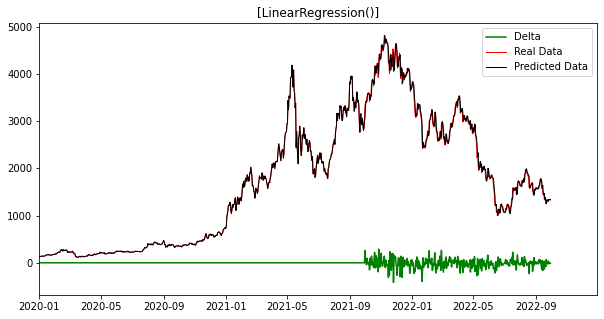

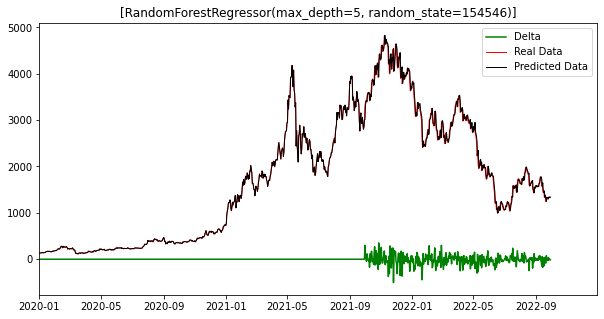

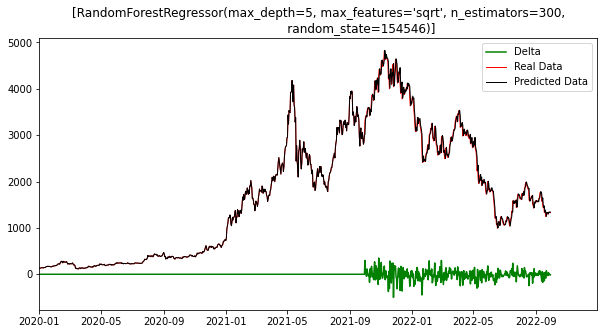

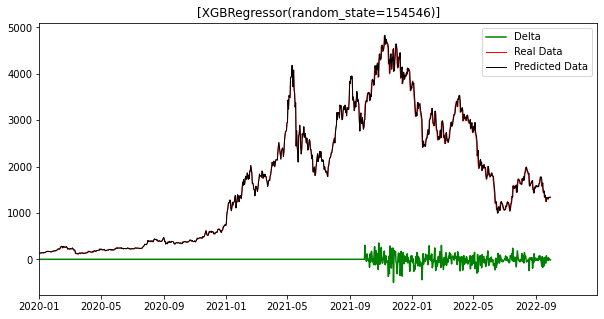

,model_name,data_frame,Mean_absolute_error,Mean_squared_error,Median_absolute_error,Explain_variance_score,R2_score,RSME
0,LinearRegression(),days,0.033396,0.002166,0.024282,0.033713,0.018856,0.046541
1,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.034883,0.003062,0.025601,-0.372691,-0.386816,0.055333
2,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.035029,0.002460,0.025821,-0.096903,-0.114361,0.049601
3,XGBRegressor(random_state=154546),days,0.035669,0.006189,0.025606,-1.784548,-1.803106,0.078667


In [11]:
df_to_model = XY_days
X_days_train, X_days_test, Y_days_train, Y_days_test = XY_experiment_dfs(df_to_model, "pct_change")

models_list = [lr, rf, rf2, xgboost]
X_training_sets = [X_days_train]
Y_training_sets = [Y_days_train]
X_test_sets = [X_days_test]
Y_test_sets = [Y_days_test]
frequency_sets = ['days']

results, predictions = experiment_outputs(models_list, X_training_sets, Y_training_sets, X_test_sets, Y_test_sets, frequency_sets)

models = len(models_list)
for i in range(0,models):
  show_model = [[models_list[i]]]
  data_viz(predictions[i][2], Y_days_train, X_days_train, Y_days_test, X_days_test,'Coin_ETH',show_model)

results

7 DAYS LAG

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


[21:11:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


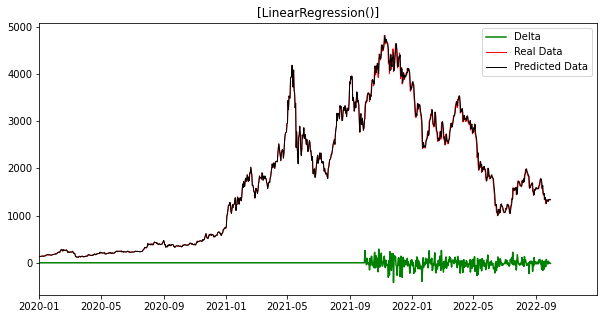

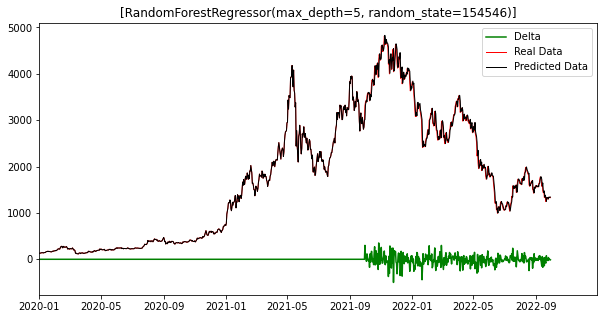

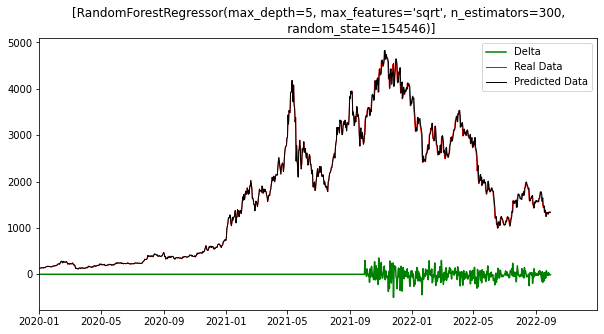

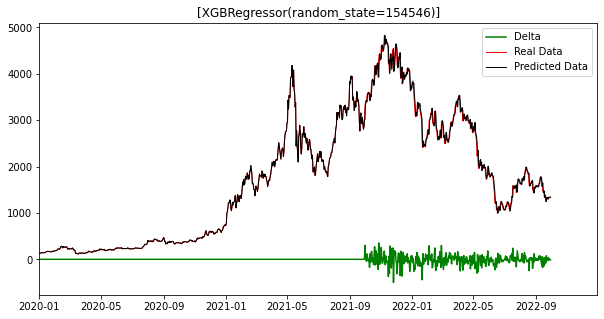

,model_name,data_frame,Mean_absolute_error,Mean_squared_error,Median_absolute_error,Explain_variance_score,R2_score,RSME
0,LinearRegression(),days,0.033401,0.002166,0.024275,0.033501,0.018693,0.046545
1,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.034387,0.002229,0.025486,0.000346,-0.009616,0.047212
2,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.034511,0.002299,0.025504,-0.028257,-0.041215,0.047945
3,XGBRegressor(random_state=154546),days,0.033883,0.002159,0.025093,0.031560,0.022277,0.046460


In [12]:
XY_days_b = XY_days
XY_days_b["close_lag_7D"] = XY_days['Close'].shift(7)

df_to_model = XY_days_b
X_days_train, X_days_test, Y_days_train, Y_days_test = XY_experiment_dfs(df_to_model, "pct_change")

models_list = [lr, rf, rf2, xgboost]
X_training_sets = [X_days_train]
Y_training_sets = [Y_days_train]
X_test_sets = [X_days_test]
Y_test_sets = [Y_days_test]
frequency_sets = ['days']

results, predictions = experiment_outputs(models_list, X_training_sets, Y_training_sets, X_test_sets, Y_test_sets, frequency_sets)

models = len(models_list)
for i in range(0,models):
  show_model = [[models_list[i]]]
  data_viz(predictions[i][2], Y_days_train, X_days_train, Y_days_test, X_days_test,'Coin_ETH',show_model)

results

- Original Features: DROPPING OPEN
- Time Features: Lag7

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


[21:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


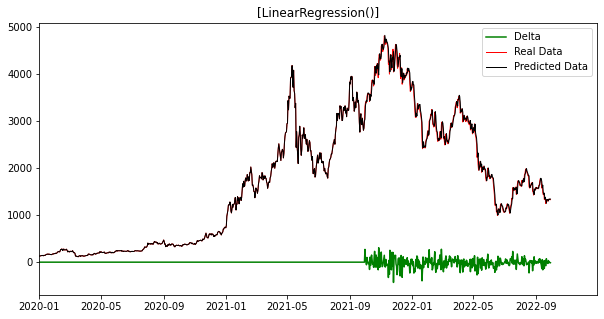

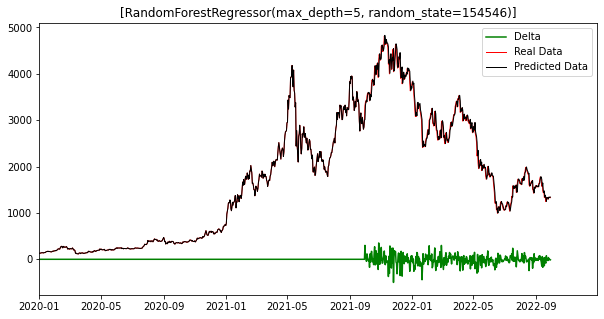

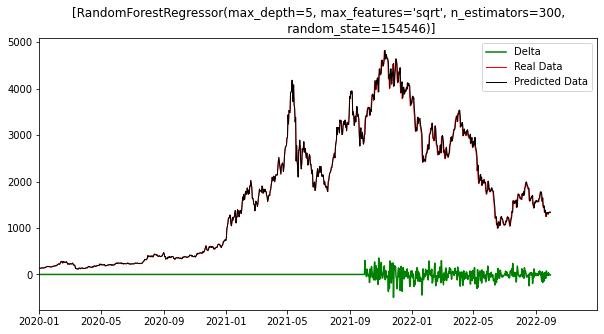

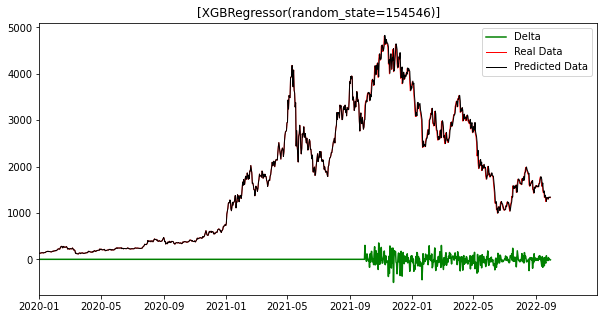

,model_name,data_frame,Mean_absolute_error,Mean_squared_error,Median_absolute_error,Explain_variance_score,R2_score,RSME
0,LinearRegression(),days,0.033850,0.002182,0.024972,0.027673,0.011607,0.046713
1,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.034387,0.002229,0.025466,0.000316,-0.009581,0.047211
2,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.034741,0.002311,0.025850,-0.032990,-0.046803,0.048073
3,XGBRegressor(random_state=154546),days,0.034184,0.002195,0.025386,0.015129,0.005705,0.046852


In [13]:
XY_days_c = XY_days

#Original Features
XY_days_c = XY_days_c.drop(['Open'], axis=1)

#Time Features
XY_days_c["close_lag_7D"] = XY_days_c['Close'].shift(7)

df_to_model = XY_days_c
X_days_train, X_days_test, Y_days_train, Y_days_test = XY_experiment_dfs(df_to_model, "pct_change")

models_list = [lr, rf, rf2, xgboost]
X_training_sets = [X_days_train]
Y_training_sets = [Y_days_train]
X_test_sets = [X_days_test]
Y_test_sets = [Y_days_test]
frequency_sets = ['days']

results, predictions = experiment_outputs(models_list, X_training_sets, Y_training_sets, X_test_sets, Y_test_sets, frequency_sets)

models = len(models_list)
for i in range(0,models):
  show_model = [[models_list[i]]]
  data_viz(predictions[i][2], Y_days_train, X_days_train, Y_days_test, X_days_test,'Coin_ETH',show_model)

results

- Original Features: DROPPING OPEN
- Time Features: Lag7, Lag28

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


[21:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


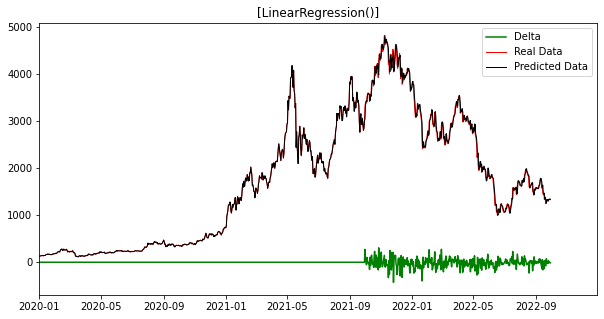

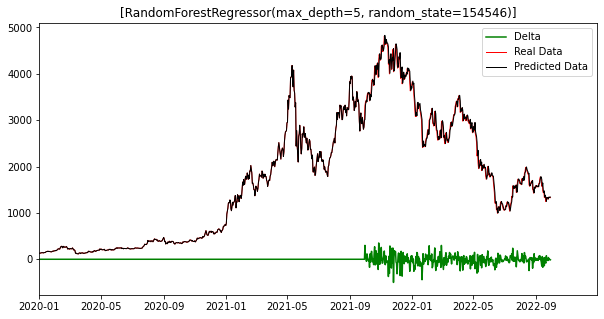

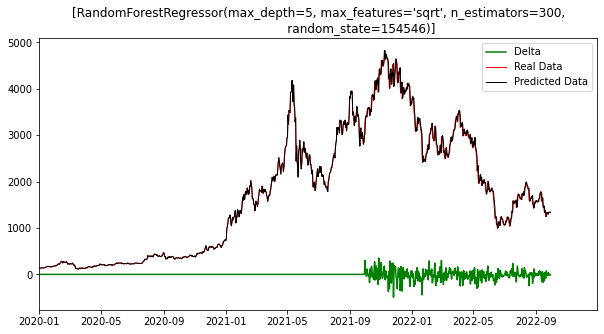

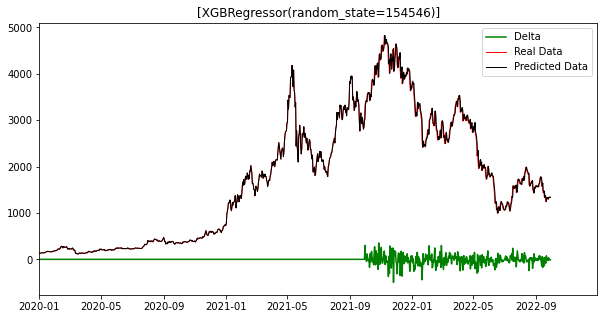

,model_name,data_frame,Mean_absolute_error,Mean_squared_error,Median_absolute_error,Explain_variance_score,R2_score,RSME
0,LinearRegression(),days,0.033863,0.002183,0.024882,0.027978,0.011346,0.046719
1,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.034374,0.002228,0.025476,0.000466,-0.009255,0.047204
2,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.034783,0.002324,0.025850,-0.038821,-0.052788,0.048211
3,XGBRegressor(random_state=154546),days,0.034164,0.002197,0.025595,0.012780,0.004959,0.046870


In [14]:
XY_days_d = XY_days

#Original Features
XY_days_d = XY_days_d.drop(['Open'], axis=1)

#Time Features
XY_days_d["close_lag_7D"] = XY_days_d['Close'].shift(7)
XY_days_d["close_lag_7D"] = XY_days_d['Close'].shift(28)


df_to_model = XY_days_d
X_days_train, X_days_test, Y_days_train, Y_days_test = XY_experiment_dfs(df_to_model, "pct_change")

models_list = [lr, rf, rf2, xgboost]
X_training_sets = [X_days_train]
Y_training_sets = [Y_days_train]
X_test_sets = [X_days_test]
Y_test_sets = [Y_days_test]
frequency_sets = ['days']

results, predictions = experiment_outputs(models_list, X_training_sets, Y_training_sets, X_test_sets, Y_test_sets, frequency_sets)

models = len(models_list)
for i in range(0,models):
  show_model = [[models_list[i]]]
  data_viz(predictions[i][2], Y_days_train, X_days_train, Y_days_test, X_days_test,'Coin_ETH',show_model)

results

- Original Features: DROPPING OPEN
- Time Features: Lag7, Lag28, Lag 365

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


[21:12:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


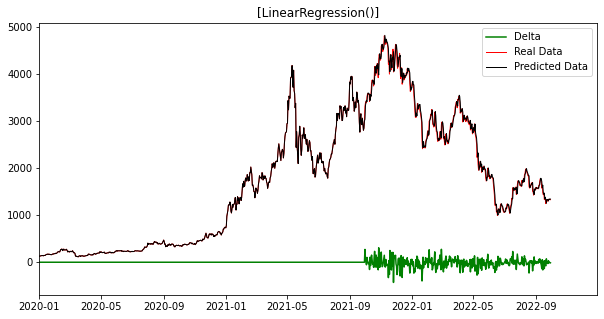

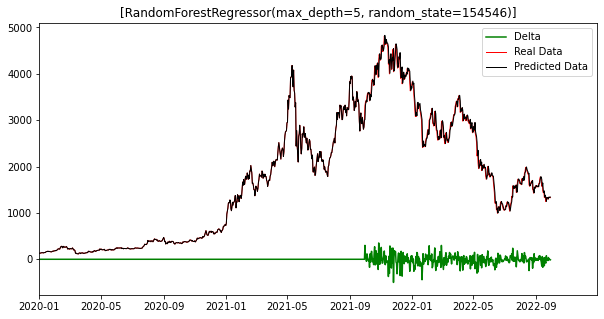

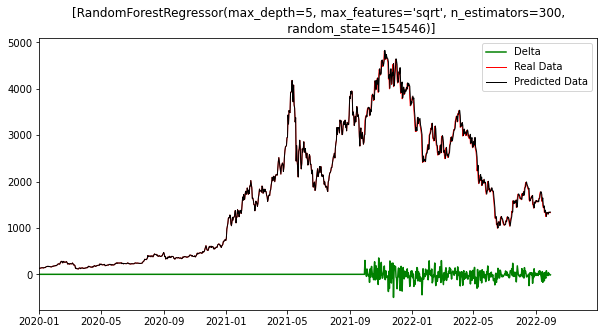

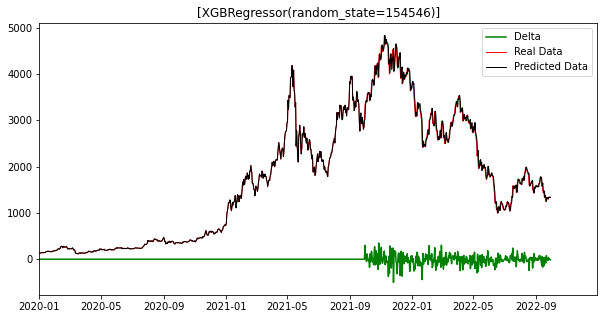

,model_name,data_frame,Mean_absolute_error,Mean_squared_error,Median_absolute_error,Explain_variance_score,R2_score,RSME
0,LinearRegression(),days,0.033966,0.002187,0.025028,0.029618,0.009545,0.046762
1,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.034592,0.002282,0.025836,-0.021011,-0.033757,0.047773
2,"(DecisionTreeRegressor(max_depth=5, max_featur...",days,0.035240,0.002420,0.026089,-0.075303,-0.096326,0.049198
3,XGBRegressor(random_state=154546),days,0.037394,0.013844,0.027215,-5.231925,-5.270663,0.117660


In [15]:
XY_days_d = XY_days

#Original Features
XY_days_d = XY_days_d.drop(['Open'], axis=1)

#Time Features
XY_days_d["close_lag_7D"] = XY_days_d['Close'].shift(7)
XY_days_d["close_lag_7D"] = XY_days_d['Close'].shift(28)
XY_days_d["close_lag_7D"] = XY_days_d['Close'].shift(365)



df_to_model = XY_days_d
X_days_train, X_days_test, Y_days_train, Y_days_test = XY_experiment_dfs(df_to_model, "pct_change")

models_list = [lr, rf, rf2, xgboost]
X_training_sets = [X_days_train]
Y_training_sets = [Y_days_train]
X_test_sets = [X_days_test]
Y_test_sets = [Y_days_test]
frequency_sets = ['days']

results, predictions = experiment_outputs(models_list, X_training_sets, Y_training_sets, X_test_sets, Y_test_sets, frequency_sets)

models = len(models_list)
for i in range(0,models):
  show_model = [[models_list[i]]]
  data_viz(predictions[i][2], Y_days_train, X_days_train, Y_days_test, X_days_test,'Coin_ETH',show_model)

results

- Check LR and RF for all COINS

In [16]:
XY_days_d

,Open Time,High,Low,Close,Volume,train_test,Crypto,Coin_ADA,Coin_BTC,Coin_ETC,Coin_ETH,Coin_LINK,Coin_LTC,Coin_TRX,Coin_XLM,Coin_XMR,Coin_XRP,pct_change,close_lag_7D
0,2018-03-01,0.38000,0.29600,0.33300,1.812000e+05,Train,ADA,1,0,0,0,0,0,0,0,0,0,NaN,NaN
1,2018-03-02,0.36000,0.30800,0.32200,3.420000e+05,Train,ADA,1,0,0,0,0,0,0,0,0,0,-0.033033,NaN
2,2018-03-03,0.33100,0.31400,0.32800,1.323000e+05,Train,ADA,1,0,0,0,0,0,0,0,0,0,0.018634,NaN
3,2018-03-04,0.34000,0.31100,0.32200,9.060000e+04,Train,ADA,1,0,0,0,0,0,0,0,0,0,-0.018293,NaN
4,2018-03-05,0.34500,0.31900,0.32100,2.557000e+05,Train,ADA,1,0,0,0,0,0,0,0,0,0,-0.003106,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20741,2022-09-25,0.52179,0.47547,0.49212,3.599211e+07,Test,XRP,0,0,0,0,0,0,0,0,0,1,0.008236,0.874
20742,2022-09-26,0.50245,0.45790,0.46791,3.374279e+07,Test,XRP,0,0,0,0,0,0,0,0,0,1,-0.049195,1.004
20743,2022-09-28,0.45579,0.41706,0.44890,2.168904e+07,Test,XRP,0,0,0,0,0,0,0,0,0,1,-0.040627,1.002
20744,2022-09-29,0.50952,0.42590,0.48605,1.244374e+08,Test,XRP,0,0,0,0,0,0,0,0,0,1,0.082758,0.945


In [17]:
XY_days_d.loc[(XY_days_d['train_test']=='Test')]['pct_change']

1310     0.066163
1311    -0.003103
1312     0.001779
1313    -0.027075
1314     0.019161
           ...   
20741    0.008236
20742   -0.049195
20743   -0.040627
20744    0.082758
20745   -0.011954
Name: pct_change, Length: 3621, dtype: float64

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


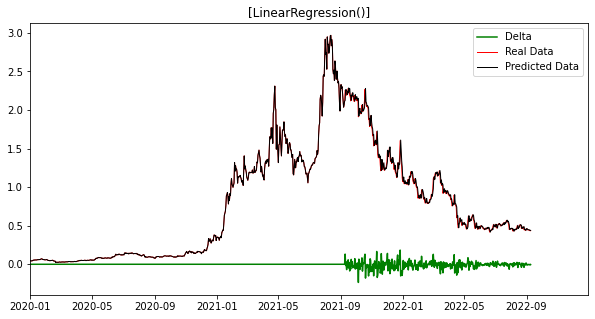

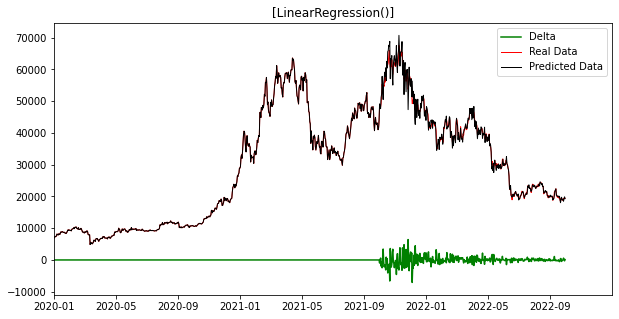

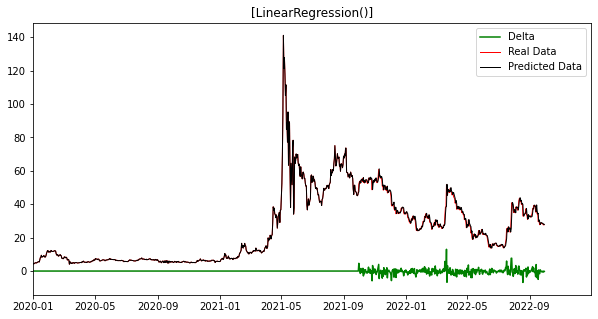

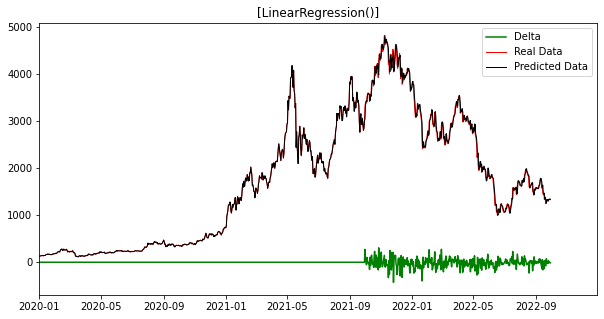

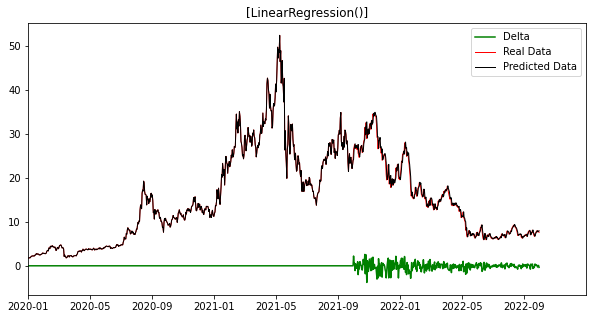

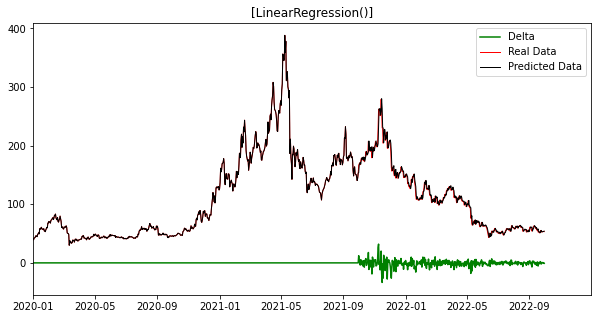

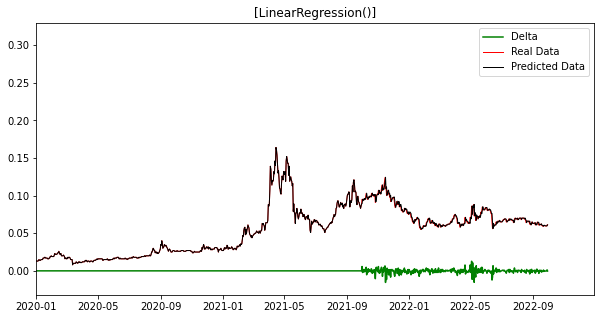

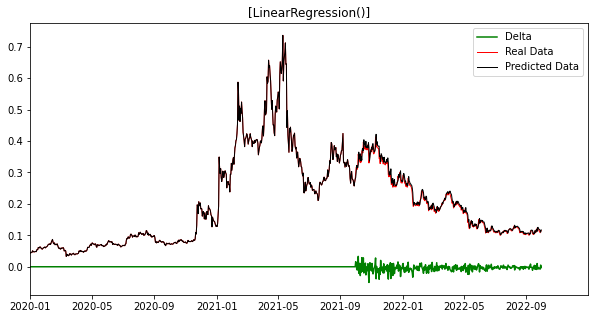

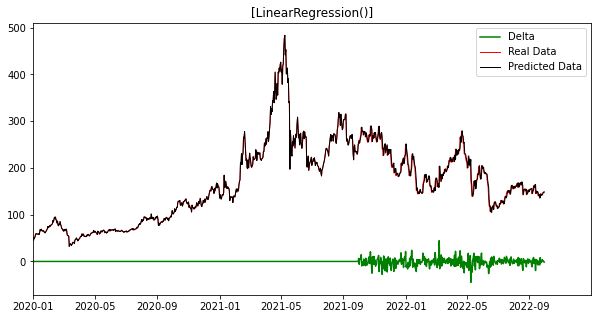

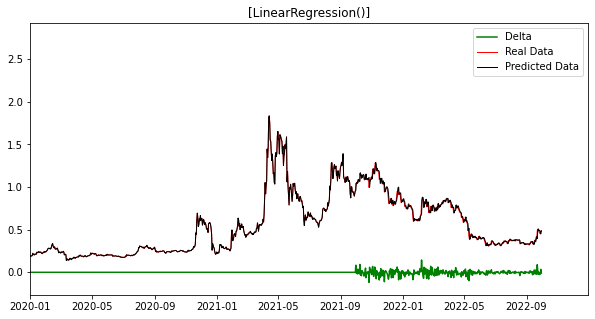

In [18]:
XY_days_d = XY_days

#Original Features
XY_days_d = XY_days_d.drop(['Open'], axis=1)

#Time Features
XY_days_d["close_lag_7D"] = XY_days_d['Close'].shift(7)
XY_days_d["close_lag_7D"] = XY_days_d['Close'].shift(28)

#Set the new features
df_to_model = XY_days_d
X_days_train, X_days_test, Y_days_train, Y_days_test = XY_experiment_dfs(df_to_model, "pct_change")

#Setting Parameters for "Experiment"
models_list = [lr]
X_training_sets = [X_days_train]
Y_training_sets = [Y_days_train]
X_test_sets = [X_days_test]
Y_test_sets = [Y_days_test]
frequency_sets = ['days']

#Running Models and Overall_Data
results, predictions = experiment_outputs(models_list, X_training_sets, Y_training_sets, X_test_sets, Y_test_sets, frequency_sets)


#Prepare Outputs and Visualizations
coins_name = ['Coin_ADA',	'Coin_BTC',	'Coin_ETC',	'Coin_ETH',	'Coin_LINK',	'Coin_LTC',	'Coin_TRX',	'Coin_XLM',	'Coin_XMR',	'Coin_XRP']
for x in coins_name:

  models = len(models_list)
  for i in range(0,models):
    show_model = [[models_list[i]]]
    data_viz(predictions[i][2], Y_days_train, X_days_train, Y_days_test, X_days_test,x,show_model)